In [1]:
#@title ConvNext models for Keras
"""ConvNeXt models for Keras.
References:
- [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)
  (CVPR 2022)
"""

import numpy as np
import tensorflow.compat.v2 as tf

from keras import backend
from keras import layers
from keras import utils
from keras.applications import imagenet_utils
from keras.engine import sequential
from keras.engine import training as training_lib

# isort: off
from tensorflow.python.util.tf_export import keras_export

BASE_WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/convnext/"
)

WEIGHTS_HASHES = {
    "convnext_tiny": (
        "8ae6e78ce2933352b1ef4008e6dd2f17bc40771563877d156bc6426c7cf503ff",
        "d547c096cabd03329d7be5562c5e14798aa39ed24b474157cef5e85ab9e49ef1",
    ),
    "convnext_small": (
        "ce1277d8f1ee5a0ef0e171469089c18f5233860ceaf9b168049cb9263fd7483c",
        "6fc8009faa2f00c1c1dfce59feea9b0745eb260a7dd11bee65c8e20843da6eab",
    ),
    "convnext_base": (
        "52cbb006d3dadd03f6e095a8ca1aca47aecdd75acb4bc74bce1f5c695d0086e6",
        "40a20c5548a5e9202f69735ecc06c990e6b7c9d2de39f0361e27baeb24cb7c45",
    ),
    "convnext_large": (
        "070c5ed9ed289581e477741d3b34beffa920db8cf590899d6d2c67fba2a198a6",
        "96f02b6f0753d4f543261bc9d09bed650f24dd6bc02ddde3066135b63d23a1cd",
    ),
    "convnext_xlarge": (
        "c1f5ccab661354fc3a79a10fa99af82f0fbf10ec65cb894a3ae0815f17a889ee",
        "de3f8a54174130e0cecdc71583354753d557fcf1f4487331558e2a16ba0cfe05",
    ),
}


MODEL_CONFIGS = {
    "tiny": {
        "depths": [3, 3, 9, 3],
        "projection_dims": [96, 192, 384, 768],
        "default_size": 224,
    },
    "small": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [96, 192, 384, 768],
        "default_size": 224,
    },
    "base": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [128, 256, 512, 1024],
        "default_size": 224,
    },
    "large": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [192, 384, 768, 1536],
        "default_size": 224,
    },
    "xlarge": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [256, 512, 1024, 2048],
        "default_size": 224,
    },
}

BASE_DOCSTRING = """Instantiates the {name} architecture.
  References:
    - [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)
    (CVPR 2022)
  For image classification use cases, see
  [this page for detailed examples](
  https://keras.io/api/applications/#usage-examples-for-image-classification-models).
  For transfer learning use cases, make sure to read the
  [guide to transfer learning & fine-tuning](
    https://keras.io/guides/transfer_learning/).
  The `base`, `large`, and `xlarge` models were first pre-trained on the
  ImageNet-21k dataset and then fine-tuned on the ImageNet-1k dataset. The
  pre-trained parameters of the models were assembled from the
  [official repository](https://github.com/facebookresearch/ConvNeXt). To get a
  sense of how these parameters were converted to Keras compatible parameters,
  please refer to
  [this repository](https://github.com/sayakpaul/keras-convnext-conversion).
  Note: Each Keras Application expects a specific kind of input preprocessing.
  For ConvNeXt, preprocessing is included in the model using a `Normalization`
  layer.  ConvNeXt models expect their inputs to be float or uint8 tensors of
  pixels with values in the [0-255] range.
  When calling the `summary()` method after instantiating a ConvNeXt model,
  prefer setting the `expand_nested` argument `summary()` to `True` to better
  investigate the instantiated model.
  Args:
    include_top: Whether to include the fully-connected
      layer at the top of the network. Defaults to True.
    weights: One of `None` (random initialization),
      `"imagenet"` (pre-training on ImageNet-1k), or the path to the weights
      file to be loaded. Defaults to `"imagenet"`.
    input_tensor: Optional Keras tensor
      (i.e. output of `layers.Input()`)
      to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
      if `include_top` is False.
      It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
      when `include_top` is `False`. Defaults to None.
      - `None` means that the output of the model will be
        the 4D tensor output of the last convolutional layer.
      - `avg` means that global average pooling
        will be applied to the output of the
        last convolutional layer, and thus
        the output of the model will be a 2D tensor.
      - `max` means that global max pooling will
        be applied.
    classes: Optional number of classes to classify images
      into, only to be specified if `include_top` is True, and
      if no `weights` argument is specified. Defaults to 1000 (number of
      ImageNet classes).
    classifier_activation: A `str` or callable. The activation function to use
      on the "top" layer. Ignored unless `include_top=True`. Set
      `classifier_activation=None` to return the logits of the "top" layer.
      Defaults to `"softmax"`.
      When loading pretrained weights, `classifier_activation` can only
      be `None` or `"softmax"`.
  Returns:
    A `keras.Model` instance.
"""


class StochasticDepth(layers.Layer):
    """Stochastic Depth module.
    It performs batch-wise dropping rather than sample-wise. In libraries like
    `timm`, it's similar to `DropPath` layers that drops residual paths
    sample-wise.
    References:
      - https://github.com/rwightman/pytorch-image-models
    Args:
      drop_path_rate (float): Probability of dropping paths. Should be within
        [0, 1].
    Returns:
      Tensor either with the residual path dropped or kept.
    """

    def __init__(self, drop_path_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_rate = drop_path_rate

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path_rate
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_path_rate": self.drop_path_rate})
        return config


class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config


def ConvNeXtBlock(
    projection_dim, drop_path_rate=0.0, layer_scale_init_value=1e-6, name=None
):
    """ConvNeXt block.
    References:
    - https://arxiv.org/abs/2201.03545
    - https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
    Notes:
      In the original ConvNeXt implementation (linked above), the authors use
      `Dense` layers for pointwise convolutions for increased efficiency.
      Following that, this implementation also uses the same.
    Args:
      projection_dim (int): Number of filters for convolution layers. In the
        ConvNeXt paper, this is referred to as projection dimension.
      drop_path_rate (float): Probability of dropping paths. Should be within
        [0, 1].
      layer_scale_init_value (float): Layer scale value. Should be a small float
        number.
      name: name to path to the keras layer.
    Returns:
      A function representing a ConvNeXtBlock block.
    """
    if name is None:
        name = "prestem" + str(backend.get_uid("prestem"))

    def apply(inputs):
        x = inputs

        x = layers.Conv2D(
            filters=projection_dim,
            kernel_size=7,
            padding="same",
            groups=projection_dim,
            name=name + "_depthwise_conv",
        )(x)
        x = layers.LayerNormalization(epsilon=1e-6, name=name + "_layernorm")(x)
        x = layers.Dense(4 * projection_dim, name=name + "_pointwise_conv_1")(x)
        x = layers.Activation("gelu", name=name + "_gelu")(x)
        x = layers.Dense(projection_dim, name=name + "_pointwise_conv_2")(x)

        if layer_scale_init_value is not None:
            x = LayerScale(
                layer_scale_init_value,
                projection_dim,
                name=name + "_layer_scale",
            )(x)
        if drop_path_rate:
            layer = StochasticDepth(
                drop_path_rate, name=name + "_stochastic_depth"
            )
        else:
            layer = layers.Activation("linear", name=name + "_identity")

        return inputs + layer(x)

    return apply


def PreStem(name=None):
    """Normalizes inputs with ImageNet-1k mean and std.
    Args:
      name (str): Name prefix.
    Returns:
      A presemt function.
    """
    if name is None:
        name = "prestem" + str(backend.get_uid("prestem"))

    def apply(x):
        x = layers.Normalization(
            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
            variance=[
                (0.229 * 255) ** 2,
                (0.224 * 255) ** 2,
                (0.225 * 255) ** 2,
            ],
            name=name + "_prestem_normalization",
        )(x)
        return x

    return apply


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


def ConvNeXt(
    depths,
    projection_dims,
    drop_path_rate=0.0,
    layer_scale_init_value=1e-6,
    default_size=224,
    model_name="convnext",
    include_preprocessing=True,
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates ConvNeXt architecture given specific configuration.
    Args:
      depths: An iterable containing depths for each individual stages.
      projection_dims: An iterable containing output number of channels of
      each individual stages.
      drop_path_rate: Stochastic depth probability. If 0.0, then stochastic
        depth won't be used.
      layer_scale_init_value: Layer scale coefficient. If 0.0, layer scaling
        won't be used.
      default_size: Default input image size.
      model_name: An optional name for the model.
      include_preprocessing: boolean denoting whther to include preprocessing in
        the model. When `weights="imagenet"` this should be always set to True.
        But for other models (e.g., randomly initialized) users should set it
        to False and apply preprocessing to data accordingly.
      include_top: Boolean denoting whether to include classification head to
        the model.
      weights: one of `None` (random initialization), `"imagenet"` (pre-training
        on ImageNet-1k), or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor (i.e. output of `layers.Input()`) to
        use as image input for the model.
      input_shape: optional shape tuple, only to be specified if `include_top`
        is False. It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction when `include_top`
        is `False`.
        - `None` means that the output of the model will be the 4D tensor output
          of the last convolutional layer.
        - `avg` means that global average pooling will be applied to the output
          of the last convolutional layer, and thus the output of the model will
          be a 2D tensor.
        - `max` means that global max pooling will be applied.
      classes: optional number of classes to classify images into, only to be
        specified if `include_top` is True, and if no `weights` argument is
        specified.
      classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
    Returns:
      A `keras.Model` instance.
    Raises:
        ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
        ValueError: if `classifier_activation` is not `softmax`, or `None`
          when using a pretrained top layer.
        ValueError: if `include_top` is True but `num_classes` is not 1000
          when using ImageNet.
    """
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights` as `'imagenet'` with `include_top`"
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape.
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if input_tensor is not None:
        inputs = utils.layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    x = inputs
    if include_preprocessing:
        channel_axis = (
            3 if backend.image_data_format() == "channels_last" else 1
        )
        num_channels = input_shape[channel_axis - 1]
        if num_channels == 3:
            x = PreStem(name=model_name)(x)

    # Stem block.
    stem = sequential.Sequential(
        [
            layers.Conv2D(
                projection_dims[0],
                kernel_size=4,
                strides=4,
                name=model_name + "_stem_conv",
            ),
            layers.LayerNormalization(
                epsilon=1e-6, name=model_name + "_stem_layernorm"
            ),
        ],
        name=model_name + "_stem",
    )

    # Downsampling blocks.
    downsample_layers = []
    downsample_layers.append(stem)

    num_downsample_layers = 3
    for i in range(num_downsample_layers):
        downsample_layer = sequential.Sequential(
            [
                layers.LayerNormalization(
                    epsilon=1e-6,
                    name=model_name + "_downsampling_layernorm_" + str(i),
                ),
                layers.Conv2D(
                    projection_dims[i + 1],
                    kernel_size=2,
                    strides=2,
                    name=model_name + "_downsampling_conv_" + str(i),
                ),
            ],
            name=model_name + "_downsampling_block_" + str(i),
        )
        downsample_layers.append(downsample_layer)

    # Stochastic depth schedule.
    # This is referred from the original ConvNeXt codebase:
    # https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py#L86
    depth_drop_rates = [
        float(x) for x in np.linspace(0.0, drop_path_rate, sum(depths))
    ]

    # First apply downsampling blocks and then apply ConvNeXt stages.
    cur = 0

    num_convnext_blocks = 4
    for i in range(num_convnext_blocks):
        x = downsample_layers[i](x)
        for j in range(depths[i]):
            x = ConvNeXtBlock(
                projection_dim=projection_dims[i],
                drop_path_rate=depth_drop_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value,
                name=model_name + f"_stage_{i}_block_{j}",
            )(x)
        cur += depths[i]

    if include_top:
        x = Head(num_classes=classes, name=model_name)(x)
        imagenet_utils.validate_activation(classifier_activation, weights)

    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    model = training_lib.Model(inputs=inputs, outputs=x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        if include_top:
            file_suffix = ".h5"
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_suffix = "_notop.h5"
            file_hash = WEIGHTS_HASHES[model_name][1]
        file_name = model_name + file_suffix
        weights_path = utils.data_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


## Instantiating variants ##


@keras_export(
    "keras.applications.convnext.ConvNeXtTiny",
    "keras.applications.ConvNeXtTiny",
)
def ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["tiny"]["depths"],
        projection_dims=MODEL_CONFIGS["tiny"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["tiny"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtSmall",
    "keras.applications.ConvNeXtSmall",
)
def ConvNeXtSmall(
    model_name="convnext_small",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["small"]["depths"],
        projection_dims=MODEL_CONFIGS["small"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["small"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtBase",
    "keras.applications.ConvNeXtBase",
)
def ConvNeXtBase(
    model_name="convnext_base",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["base"]["depths"],
        projection_dims=MODEL_CONFIGS["base"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["base"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtLarge",
    "keras.applications.ConvNeXtLarge",
)
def ConvNeXtLarge(
    model_name="convnext_large",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["large"]["depths"],
        projection_dims=MODEL_CONFIGS["large"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["large"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtXLarge",
    "keras.applications.ConvNeXtXLarge",
)
def ConvNeXtXLarge(
    model_name="convnext_xlarge",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["xlarge"]["depths"],
        projection_dims=MODEL_CONFIGS["xlarge"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["xlarge"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


ConvNeXtTiny.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtTiny")
ConvNeXtSmall.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtSmall")
ConvNeXtBase.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtBase")
ConvNeXtLarge.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtLarge")
ConvNeXtXLarge.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtXLarge")


@keras_export("keras.applications.convnext.preprocess_input")
def preprocess_input(x, data_format=None):
    """A placeholder method for backward compatibility.
    The preprocessing logic has been included in the convnext model
    implementation. Users are no longer required to call this method to
    normalize the input data. This method does nothing and only kept as a
    placeholder to align the API surface between old and new version of model.
    Args:
      x: A floating point `numpy.array` or a `tf.Tensor`.
      data_format: Optional data format of the image tensor/array. Defaults to
        None, in which case the global setting
        `tf.keras.backend.image_data_format()` is used (unless you changed it,
        it defaults to "channels_last").{mode}
    Returns:
      Unchanged `numpy.array` or `tf.Tensor`.
    """
    return x


@keras_export("keras.applications.convnext.decode_predictions")
def decode_predictions(preds, top=5):
    return imagenet_utils.decode_predictions(preds, top=top)

ModuleNotFoundError: ignored

Connecting notebook to GDRIVE

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/10COWIrpNjRB7JEC3eCreSVn5whkZxmFb/ANDL1


Importing modules and libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from keras.callbacks import EarlyStopping
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Setting dataset directory

In [ ]:
dataset_dir = 'cleaned_by_ALBERTO_split'
training_dir = os.path.join(dataset_dir,'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
dataset_img_size = (96, 96)
dataset_img_shape = (96, 96, 3)

In [ ]:
labels = ['Species1',
          'Species2',
          'Species3',
          'Species4',
          'Species5',
          'Species6',
          'Species7',
          'Species8']

Using ImageDataGenerator for data augmentation

In [ ]:
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()


aug_train_data_gen = ImageDataGenerator(
                                        preprocessing_function=None,
                                        rotation_range=180,
                                        height_shift_range=0.4,
                                        width_shift_range=0.4,
                                        zoom_range=0.4,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        )

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=dataset_img_size,
                                               color_mode='rgb',
                                               classes=labels,
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=dataset_img_size,
                                               color_mode='rgb',
                                               classes=labels,
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=dataset_img_size,
                                              color_mode='rgb',
                                              classes=labels,
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=False,
                                              seed=seed)


Found 3060 images belonging to 8 classes.
Found 686 images belonging to 8 classes.
Found 82 images belonging to 8 classes.


Creation of the model, pretrained on imagenet

In [ ]:
ConvNextB = ConvNeXtLarge(
    input_shape=dataset_img_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None
)

785596384/785596384 [==============================] - 20s 0us/step


In [ ]:
ConvNextB.summary()

Model: "convnext_large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 convnext_large_prestem_normali  (None, 96, 96, 3)   0           ['input_1[0][0]']                
 zation (Normalization)                                                                           
                                                                                                  
 convnext_large_stem (Sequentia  (None, 24, 24, 192)  9792       ['convnext_large_prestem_normaliz
 l)                                                              ation[0][0]']                    
                                                                                     

In [ ]:
ConvNextB.trainable = False

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    transfer_learning_layer = ConvNextB(input_layer)

    flattening_layer = tfkl.Flatten(name='Flatten')(transfer_learning_layer)

    flattering_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(
        units=256,
        name='Classifier',
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(
        units=len(labels),
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1E-4), metrics='accuracy')

    return model

In [ ]:
model = build_model(dataset_img_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 Flatten (Flatten)           (None, 13824)             0         
                                                                 
 Classifier (Dense)          (None, 256)               3539200   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                                 
Total params: 199,771,592
Trainable params: 3,541,256
Non-tra

Fitting the model to the training data using early stopping to prevent overfitting


In [ ]:
from keras.callbacks import EarlyStopping
epochs = 200
batch_size = 32

history = model.fit(
    x = aug_train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
96/96 [==============================] - 1045s 11s/step - loss: 1.6164 - accuracy: 0.4395 - val_loss: 0.9467 - val_accuracy: 0.6531
Epoch 2/200
96/96 [==============================] - 27s 276ms/step - loss: 1.1295 - accuracy: 0.6000 - val_loss: 0.7917 - val_accuracy: 0.7172
Epoch 3/200
96/96 [==============================] - 27s 285ms/step - loss: 0.9875 - accuracy: 0.6359 - val_loss: 0.7183 - val_accuracy: 0.7420
Epoch 4/200
96/96 [==============================] - 27s 286ms/step - loss: 0.9104 - accuracy: 0.6729 - val_loss: 0.6531 - val_accuracy: 0.7784
Epoch 5/200
96/96 [==============================] - 27s 281ms/step - loss: 0.8604 - accuracy: 0.6902 - val_loss: 0.5987 - val_accuracy: 0.7784
Epoch 6/200
96/96 [==============================] - 26s 274ms/step - loss: 0.8123 - accuracy: 0.7095 - val_loss: 0.5828 - val_accuracy: 0.7857
Epoch 7/200
96/96 [==============================] - 27s 276ms/step - loss: 0.7977 - accuracy: 0.7160 - val_loss: 0.5878 - val_accuracy:

Saving the model

In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
model.save('ConvNeXtLarge_noOutliersAlbi')

/gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet


Plotting the results

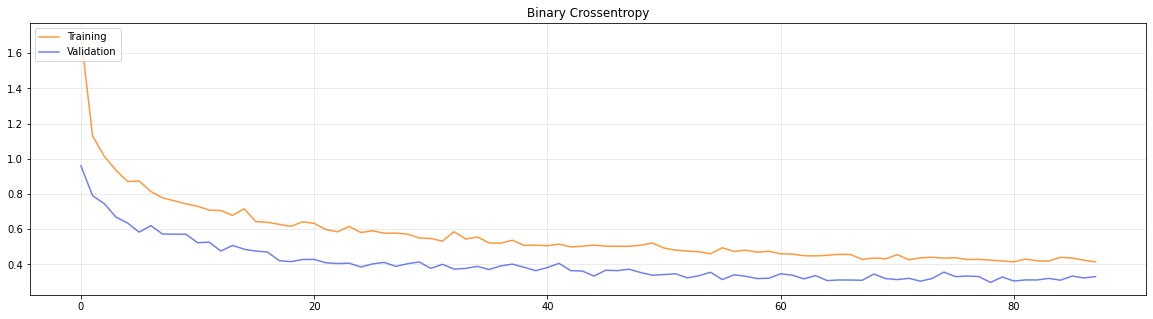

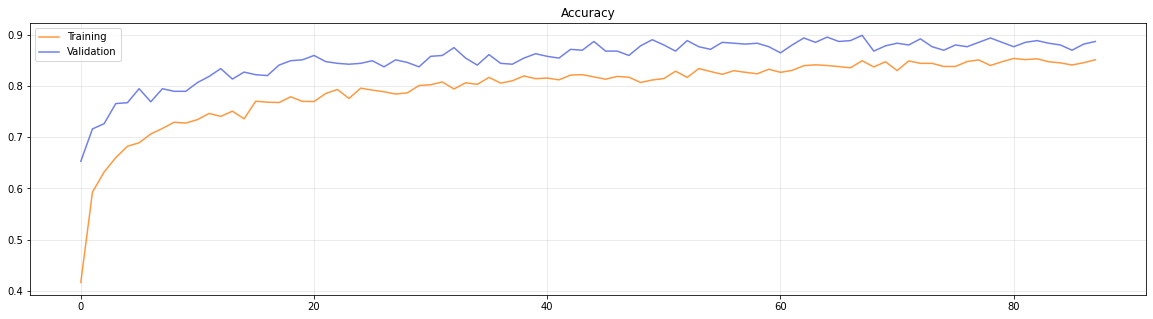

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

**Fine tuning of the previous model**

In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
ft_model = tfk.models.load_model('ConvNeXtLarge_noOutliersAlbi')
ft_model.summary()

/gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 Flatten (Flatten)           (None, 13824)             0         
                                                                 
 Classifier (Dense)          (None, 256)               3539200   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                                 
Total params: 19

In [ ]:
ft_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_pointwis

In [ ]:
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:220+1]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_large_stage_0_block_1_depthwise_conv False
12 convnext_large_stage_0_block_1_layernorm False
13 convnext_large_stage_0_block_1_pointwise_conv_1 False
14 convnext_large_stage_0_block_1_gelu False
15 convnext_large_stage_0_block_1_pointwise_conv_2 False
16 convnext_large_stage_0_block_1_layer_scale False
17 convnext_large_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_large_stage_0_block_2_depthwise_conv False
20 convnext_large_stage_0_block_2_layernorm False
21 convnext_large_sta

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
%cd /gdrive/My Drive/ANDL1

/gdrive/My Drive/ANDL1


In [ ]:
ft_history = ft_model.fit(
    x = aug_train_gen,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)] # first patience=10
).history


Epoch 1/200
96/96 [==============================] - 1850s 19s/step - loss: 0.4143 - accuracy: 0.8546 - val_loss: 0.2993 - val_accuracy: 0.8950
Epoch 2/200
96/96 [==============================] - 37s 380ms/step - loss: 0.3790 - accuracy: 0.8693 - val_loss: 0.3177 - val_accuracy: 0.9038
Epoch 3/200
96/96 [==============================] - 36s 374ms/step - loss: 0.3648 - accuracy: 0.8716 - val_loss: 0.2846 - val_accuracy: 0.9009
Epoch 4/200
96/96 [==============================] - 36s 373ms/step - loss: 0.3400 - accuracy: 0.8817 - val_loss: 0.3038 - val_accuracy: 0.8936
Epoch 5/200
96/96 [==============================] - 36s 373ms/step - loss: 0.3190 - accuracy: 0.8830 - val_loss: 0.3723 - val_accuracy: 0.8688
Epoch 6/200
96/96 [==============================] - 36s 371ms/step - loss: 0.3396 - accuracy: 0.8810 - val_loss: 0.2819 - val_accuracy: 0.8921
Epoch 7/200
96/96 [==============================] - 36s 374ms/step - loss: 0.3528 - accuracy: 0.8768 - val_loss: 0.3413 - val_accuracy:

In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
ft_model.save('ConvNeXtLarge_ft1_noOutAlbi')

/gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet


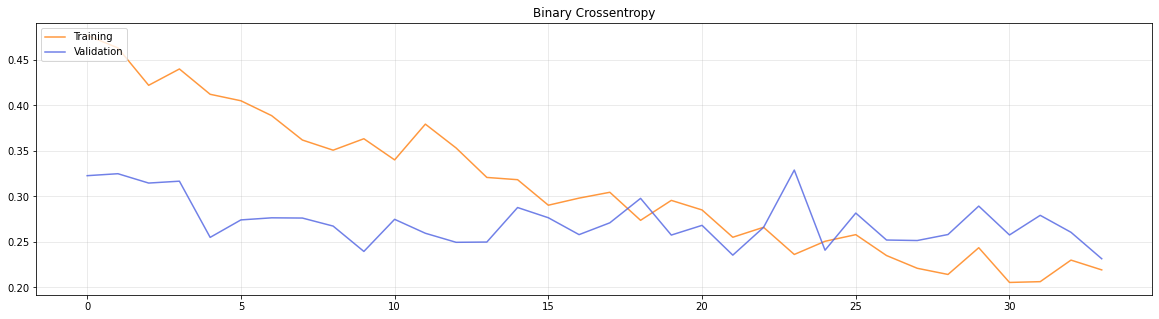

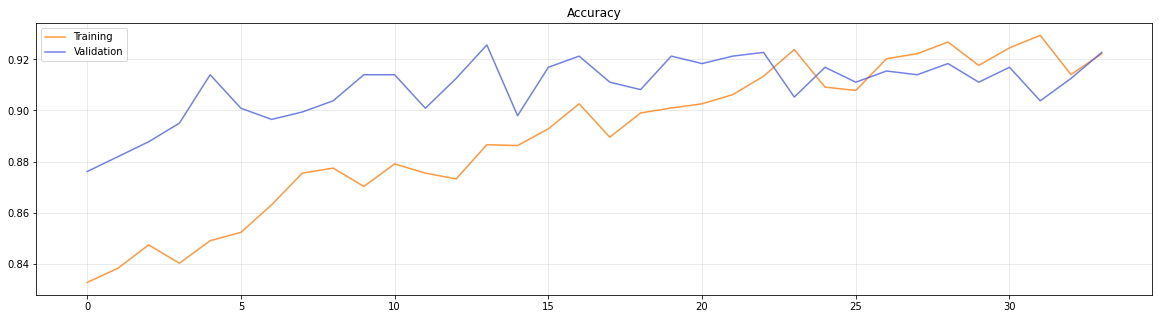

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ft_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(ft_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Second Fine tuning


*   Using more data for training, split only between training and validation
*   No test set



In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
ft_model = tfk.models.load_model('ConvNeXtLarge_ft1_noOutAlbi')
ft_model.summary()

%cd /gdrive/My Drive/ANDL1

/gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 Flatten (Flatten)           (None, 13824)             0         
                                                                 
 Classifier (Dense)          (None, 256)               3539200   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                                 
Total params: 19

In [ ]:
ft_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_pointwis

In [ ]:
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:188+1]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_large_stage_0_block_1_depthwise_conv False
12 convnext_large_stage_0_block_1_layernorm False
13 convnext_large_stage_0_block_1_pointwise_conv_1 False
14 convnext_large_stage_0_block_1_gelu False
15 convnext_large_stage_0_block_1_pointwise_conv_2 False
16 convnext_large_stage_0_block_1_layer_scale False
17 convnext_large_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_large_stage_0_block_2_depthwise_conv False
20 convnext_large_stage_0_block_2_layernorm False
21 convnext_large_sta

In [ ]:
dataset_dir = 'cleaned_by_Alberto_TRAINsuTutto_PreSub'
training_dir = os.path.join(dataset_dir,'train')
validation_dir = os.path.join(dataset_dir, 'val')
valid_data_gen = ImageDataGenerator()


aug_train_data_gen = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,
                                        rotation_range=180,
                                        height_shift_range=0.4,
                                        width_shift_range=0.4,
                                        zoom_range=0.4,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        )


aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=dataset_img_size,
                                               color_mode='rgb',
                                               classes=labels,
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=dataset_img_size,
                                               color_mode='rgb',
                                               classes=labels,
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)

Found 3443 images belonging to 8 classes.
Found 385 images belonging to 8 classes.


In [ ]:
batch_size = 32
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 Flatten (Flatten)           (None, 13824)             0         
                                                                 
 Classifier (Dense)          (None, 256)               3539200   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                                 
Total params: 199,771,592
Trainable params: 112,787,720
Non-t

In [ ]:
ft_history = ft_model.fit(
    x = aug_train_gen,
    batch_size = batch_size,
    epochs = 100,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/100
108/108 [==============================] - 1820s 17s/step - loss: 0.3605 - accuracy: 0.8754 - val_loss: 0.2614 - val_accuracy: 0.9013
Epoch 2/100
108/108 [==============================] - 39s 358ms/step - loss: 0.3086 - accuracy: 0.8917 - val_loss: 0.2598 - val_accuracy: 0.9169
Epoch 3/100
108/108 [==============================] - 38s 348ms/step - loss: 0.3243 - accuracy: 0.8885 - val_loss: 0.3216 - val_accuracy: 0.8961
Epoch 4/100
108/108 [==============================] - 38s 349ms/step - loss: 0.3153 - accuracy: 0.8911 - val_loss: 0.3091 - val_accuracy: 0.9091
Epoch 5/100
108/108 [==============================] - 40s 372ms/step - loss: 0.3218 - accuracy: 0.8888 - val_loss: 0.2900 - val_accuracy: 0.8961
Epoch 6/100
108/108 [==============================] - 38s 348ms/step - loss: 0.3104 - accuracy: 0.8931 - val_loss: 0.2485 - val_accuracy: 0.9117
Epoch 7/100
108/108 [==============================] - 38s 350ms/step - loss: 0.2812 - accuracy: 0.9073 - val_loss: 0.2691 -

In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
ft_model.save('ConvNeXtLarge_ft2_noOutAlbi')

/gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet


Final training using all the data set

In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
ft_model = tfk.models.load_model('ConvNeXtLarge_ft2_noOutAlbi')
ft_model.summary()

/gdrive/My Drive/ANDL1/Prove/Alberto/ConvNet
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 Flatten (Flatten)           (None, 13824)             0         
                                                                 
 Classifier (Dense)          (None, 256)               3539200   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                                 
Total params: 19

In [ ]:
dataset_dir = 'cleaned_by_ALBERTO'
training_dir = os.path.join(dataset_dir,'train_all')

aug_train_data_gen = ImageDataGenerator(
                                        preprocessing_function=None,
                                        rotation_range=180,
                                        height_shift_range=0.4,
                                        width_shift_range=0.4,
                                        zoom_range=0.4,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        )

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=dataset_img_size,
                                               color_mode='rgb',
                                               classes=labels,
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)

Found 3828 images belonging to 8 classes.


In [ ]:
batch_size = 32

/gdrive/.shortcut-targets-by-id/10COWIrpNjRB7JEC3eCreSVn5whkZxmFb/ANDL1
320
398
396
397
408
320
429
392


Text(0.5, 1.0, 'Number of train images per category:')

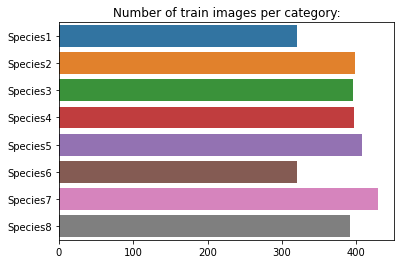

In [ ]:
%cd /gdrive/My Drive/ANDL1
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
    print(len(os.listdir(folder)))

plot = sns.barplot(y=category_names, x=img_pr_cat)
plot.set_title("Number of train images per category:")

Setting class_weight to give more importance to first class


In [ ]:
import math
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

labels_dict = {0: 400, 1: 490, 2: 490, 3: 490, 4: 490, 5: 490, 6: 490, 7: 490}
class_weights = create_class_weight(labels_dict)
class_weights

{0: 2.2591555350667094,
 1: 2.056214691070019,
 2: 2.056214691070019,
 3: 2.056214691070019,
 4: 2.056214691070019,
 5: 2.056214691070019,
 6: 2.056214691070019,
 7: 2.056214691070019}

In [ ]:
ft_history = ft_model.fit(
    x = aug_train_gen,
    batch_size = batch_size,
    epochs = 25,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=10, restore_best_weights=True)],
    class_weight = class_weights
).history

In [ ]:
%cd /gdrive/My Drive/ANDL1/Prove/Alberto
ft_model.save('ConvNeXtLarge_ft3_AllDataNoOutAlbi_CW')

/gdrive/My Drive/ANDL1/Prove/Alberto
